In [1]:
import import_ipynb
import cv2
from timeit import default_timer as timer
from collections import OrderedDict

from model_development import *
from extra_models import *

importing Jupyter notebook from model_development.ipynb
Platform: Local machine
TorchMetrics already installed.
(set(), set())
Index: 2710
Input Image: Datasets/RESIDE-6K/train/hazy/3438.jpg
Target Image: Datasets/RESIDE-6K/train/GT/3438.jpg
Input Image: Datasets/RESIDE-6K/train/hazy/1233.jpg
Target Image: Datasets/RESIDE-6K/train/GT/1233.jpg
Input Image: Datasets/RESIDE-6K/train/hazy/1503.jpg
Target Image: Datasets/RESIDE-6K/train/GT/1503.jpg
Input Image: Datasets/RESIDE-6K/train/hazy/166.jpg
Target Image: Datasets/RESIDE-6K/train/GT/166.jpg
Datasets/RESIDE-6K/train/hazy/5712.jpg
Image size: [1, 3, 400, 400]
L1 Loss: 0.2835 | PSNR: 9.8484 | SSIM: 34.85%
(set(), set())
Index: 144
Input Image: Datasets/RESIDE-6K/test/hazy/0171_0.85_0.12.jpg
Target Image: Datasets/RESIDE-6K/test/GT/0171_0.85_0.12.jpg
Datasets/RESIDE-6K/test/hazy/0056_0.8_0.16.jpg
Image size: [1, 3, 636, 548]
L1 Loss: 0.2939 | PSNR: 9.5525 | SSIM: 56.28%
importing Jupyter notebook from extra_models.ipynb


In [2]:
FROM_VIDEO = True
videos_path = 'Videos'
video_name = 'Virtual_Drive_Through_The_Dark_and_Foggy_Forest__Rain_and_Thunder_01_36_00___01_38_00.mp4'
video_loc = os.path.join(videos_path, video_name)

SKIP_INTERVAL = 2

In [3]:
model = LightClearNet().to(device)
state_dict_name = 'LightClearNet_2024-04-11_15-52-13_5epochs.pth'

IS_STATE_DICT_LOADING_EASY = True
NORMALIZE = False
RESIZE = True
IMG_HEIGHT = 400

Datasets/RESIDE-6K/train/hazy/3695.jpg
Image size: [1, 3, 400, 400]
L1 Loss: 0.1068 | PSNR: 17.5028 | SSIM: 76.56%


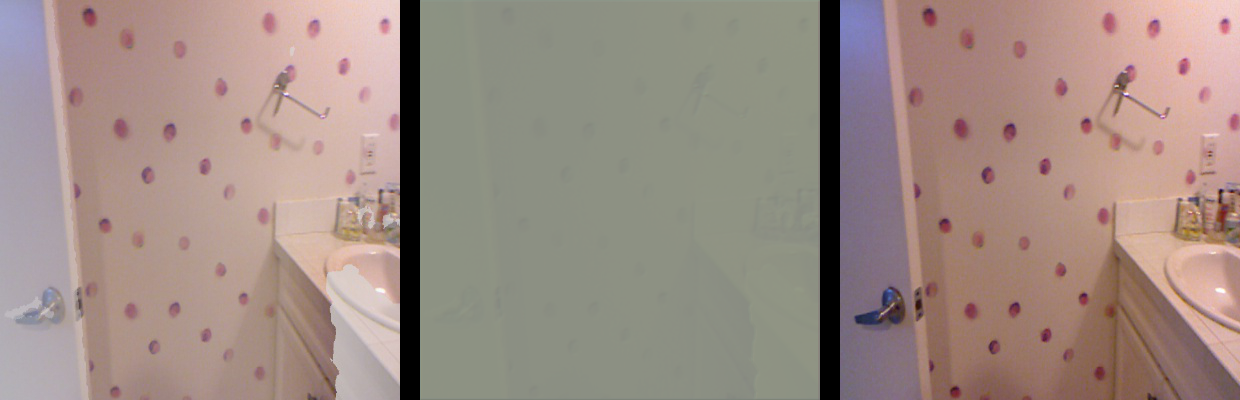

In [4]:
visualize_random_pair_pred(dataset, model, visualize_target=True, normalize=NORMALIZE)

In [5]:
state_dict_loc = os.path.join(model_save_path, state_dict_name)
print(state_dict_loc)

if IS_STATE_DICT_LOADING_EASY:
    state_dict = torch.load(state_dict_loc)
else:
    state_dict = torch.load(state_dict_loc)['state_dict']
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        name = k[7:]
        new_state_dict[name] = v

    state_dict = new_state_dict

# state_dict

models\LightClearNet_2024-04-11_15-52-13_5epochs.pth


In [6]:
model.load_state_dict(state_dict)

<All keys matched successfully>

Datasets/RESIDE-6K/test/hazy/1828_0.85_0.08.jpg
Image size: [1, 3, 412, 548]
L1 Loss: 0.0331 | PSNR: 26.5071 | SSIM: 95.72%


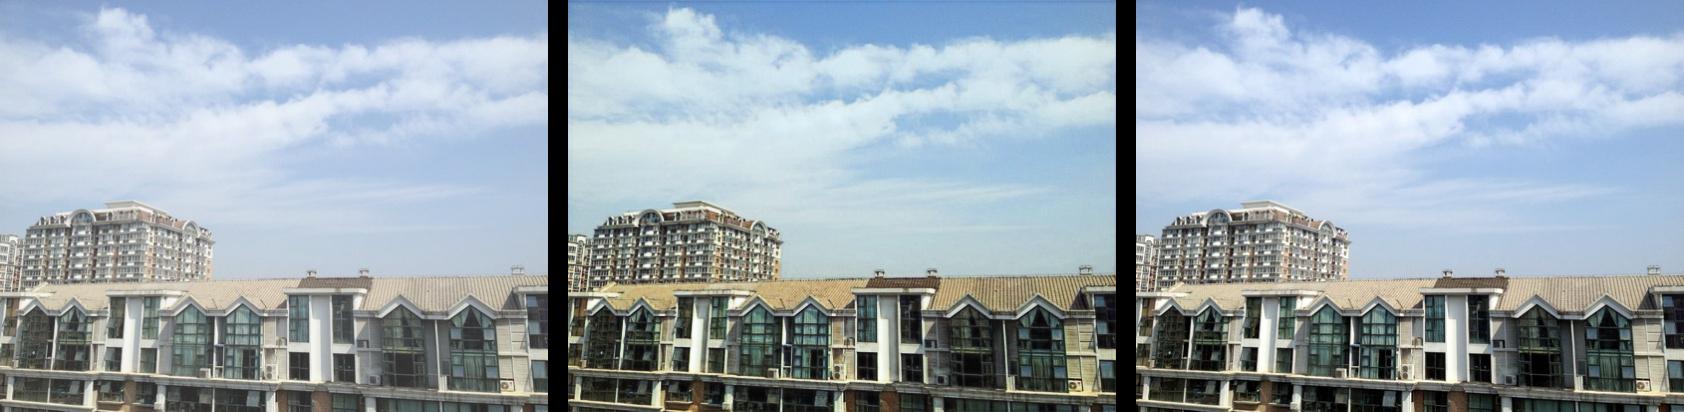

In [14]:
visualize_random_pair_pred(test_dataset, model, visualize_target=True, normalize=NORMALIZE)

In [8]:
def resize_image(image, target_height=IMG_HEIGHT):
    scale = target_height / image.height
    return image.resize((int(image.width * scale), int(image.height * scale)))

In [9]:
def frame_dehazer(frame, model):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(frame_rgb)
    if RESIZE:
        pil_img = resize_image(pil_img)
    input = img_to_tensor(pil_img).unsqueeze(0).to(device)

    model.eval()
    with torch.inference_mode():
        output = model(input)
    if NORMALIZE:
        output = normalize_tensor(output)

    dehazed_pil_img = tensor_to_img(output.squeeze())
    new_image = visualize_pair(pil_img, dehazed_pil_img, gap=0)

    return cv2.cvtColor(np.array(new_image), cv2.COLOR_BGR2RGB)

In [10]:
cap = cv2.VideoCapture(0 if not FROM_VIDEO else video_loc)

In [11]:
start_time = timer()
                   
rendered_frames = 0
video_frames = -1

while True:
    ret, frame = cap.read()

    if not ret:
        break

    video_frames += 1
    if FROM_VIDEO and video_frames % SKIP_INTERVAL != 0:
        continue

    dehazed_frame = frame_dehazer(frame, model)
    cv2.imshow('Original vs. Dehazed Video', dehazed_frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if cv2.waitKey(1) & 0xFF == ord(' '):
        while True:
            if cv2.waitKey(1) & 0xFF == ord(' '):
                break

    rendered_frames += 1

cv2.destroyAllWindows()

elapsed_time = timer() - start_time

print(f'Time Elapsed: {elapsed_time:.2f}s')
print(f'Frames: {rendered_frames} | Avg FPS: {rendered_frames / elapsed_time:.2f}')
if FROM_VIDEO:
    print(f'Video Frames: {video_frames} | Video Avg FPS: {video_frames / elapsed_time:.2f}')

Time Elapsed: 132.05s
Frames: 1501 | Avg FPS: 11.37
Video Frames: 3000 | Video Avg FPS: 22.72


In [12]:
cap.release()